In [ ]:
from nilearn.maskers import NiftiLabelsMasker
from scipy.ndimage import center_of_mass
import nibabel as nib
import numpy as np
import pandas as pd
import os

In [ ]:
# Define data directory and mapping file
data_dir = '/home/zaz22/research-data-store/fmri/fmri_beijing'
mapping_file = '/home/zaz22/research-data-store/rois/rois_3000_beijing/rois/brain_atoms.mnc.gz'  

# Define repetition time (TR)
repetition_time = 2.0

# List of subject IDs
subject_ids = ['9640133', '9783279', '9887336', '9890726', '4095748', '4136226', '4221029',
                '4225073', '4241194', '4256491', '4265987', '4334113', '4383707', '4475709',
                '4921428', '5150328', '5193577', '5575344', '5600820', '5669389', '5993008',
                '6187322', '6383713', '6477085', '6500128', '7011503', '7093319', '7135128',
                '7253183', '7390867', '7407032', '7689953', '7994085', '8191384', '8278680',]


In [3]:
# Load the ROI mapping file
mapping_img = nib.load(mapping_file)
mapping_data = mapping_img.get_fdata()
affine = mapping_img.affine

# Get unique ROI labels, excluding 0
roi_labels = np.unique(mapping_data)
roi_labels = roi_labels[roi_labels != 0]
print(f'Number of ROIs: {len(roi_labels)}')


Number of ROIs: 2843


In [4]:
# Extract ROI coordinates (center of mass)
roi_coords = []

for label in roi_labels:
    # Create a binary mask for the current ROI
    roi_mask = mapping_data == label

    # Calculate the center of mass in voxel space
    com_voxel = center_of_mass(roi_mask)

    # Convert voxel coordinates to world coordinates
    com_world = nib.affines.apply_affine(affine, com_voxel)

    roi_coords.append(com_world)

print(f'ROI coordinates (world space): {roi_coords}')


ROI coordinates (world space): [array([-52.84615385,   3.84615385,  25.92307692]), array([-37.26315789,  -7.63157895,  53.57894737]), array([-28.36363636, -23.63636364,  62.36363636]), array([-32.5       ,  -2.83333333,  44.66666667]), array([-33.64285714,  -1.42857143,  57.78571429]), array([-29. , -16.4,  64.2]), array([-39.15,   4.55,  36.85]), array([-36.        ,  -2.94117647,  62.23529412]), array([-33.75  ,  -8.3125,  47.875 ]), array([-38.45454545,   2.40909091,  42.72727273]), array([-22.25806452, -21.80645161,  64.87096774]), array([-34.09090909, -14.63636364,  56.63636364]), array([-53.68421053,   9.42105263,  38.10526316]), array([-39.85714286, -17.07142857,  56.5       ]), array([-51.77777778,   2.88888889,  18.11111111]), array([-59.59090909,   6.90909091,  25.54545455]), array([-53.78571429,  -5.5       ,  30.78571429]), array([-54.81818182,   3.36363636,  44.77272727]), array([-17.21052632, -14.42105263,  68.42105263]), array([-36.        , -21.29411765,  67.        ]),

In [5]:
# Initialize a masker for extracting time series from ROIs
labels_masker = NiftiLabelsMasker(
    labels_img=mapping_img,
    standardize=True,
    detrend=True,
    t_r=repetition_time,
    verbose=1
)

# Initialize a list to store time series for all subjects
all_tseries = []

for sub_id in subject_ids:
    # Build the functional file path
    func_file = os.path.join(data_dir, f'fmri_X_{sub_id}_session_1_run1.nii.gz')
    print(f'Loading functional image for subject {sub_id} from {func_file}')
    
    # Load the functional image
    func_img = nib.load(func_file)
    
    # Extract time series using the labels masker
    tseries = labels_masker.fit_transform(func_img)
    
    all_tseries.append(tseries)
    print(f'Extracted time series for subject {sub_id}, shape: {tseries.shape}')


Loading functional image for subject 9640133 from /home/zaz22/research-data-store/fmri/fmri_beijing/fmri_X_9640133_session_1_run1.nii.gz
[NiftiLabelsMasker.wrapped] loading data from Minc1Image('/home/zaz22/research-data-store/rois/rois_3000_beijing/rois/brain_atoms.mnc.gz')
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('/home/zaz22/research-data-store/fmri/fmri_beijing/fmri_X_9640133_session_1_run1.nii.gz')
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Extracted time series for subject 9640133, shape: (236, 2843)
Loading functional image for subject 9783279 from /home/zaz22/research-data-store/fmri/fmri_beijing/fmri_X_9783279_session_1_run1.nii.gz
[NiftiLabelsMasker.wrapped] loading data from Minc1Image('/home/zaz22/research-data-store/rois/rois_3000_beijing/rois/brain_atoms.mnc.gz')
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Ima

In [6]:
# Define file paths and parameters
behavioral_file = '/home/zaz22/repos/adhd-mri-using-ml/adhd200_preprocessed_phenotypics.tsv'  # Update with your actual file path
behavioral = pd.read_csv(behavioral_file, sep='\t')

# Define diagnosis groups
behavioral['DX'] = behavioral['DX'].astype(str).str.strip()

# Apply mapping
conditions_map = {
    '0': 'Non-ADHD',
    '1': 'ADHD',
    '2': 'ADHD',
    '3': 'ADHD'
}
behavioral['Diagnosis_Class'] = behavioral['DX'].map(conditions_map)
print(behavioral['Diagnosis_Class'].value_counts(dropna=False))


Diagnosis_Class
Non-ADHD    585
ADHD        362
NaN          26
Name: count, dtype: int64


In [7]:
# Map the diagnosis column to binary classes
behavioral['Diagnosis_Class'] = behavioral['DX'].map(conditions_map)
behavioral = behavioral.loc[behavioral['DX'] != 'pending']
print(behavioral['DX'].unique())  # Check all unique values in the DX column
print(behavioral['Diagnosis_Class'].value_counts())  # Check how the mapping works
print(behavioral[behavioral['DX'].isna()])  # Check rows where DX is NaN
print(behavioral['Diagnosis_Class'].unique())  # Check unique mapped values
print(behavioral['DX'].dtypes)  # Check if the column is numeric or string
print(behavioral['DX'].unique())  # Confirm all unique values


['0' '1' '3' '2']
Diagnosis_Class
Non-ADHD    585
ADHD        362
Name: count, dtype: int64
Empty DataFrame
Columns: [ScanDir ID, Site, Gender, Age, Handedness, DX, Secondary Dx, ADHD Measure, ADHD Index, Inattentive, Hyper/Impulsive, IQ Measure, Verbal IQ, Performance IQ, Full2 IQ, Full4 IQ, Med Status, QC_Athena, QC_NIAK, Diagnosis_Class]
Index: []
['Non-ADHD' 'ADHD']
object
['0' '1' '3' '2']


In [ ]:
# Filter data for valid diagnosis classes
condition_mask = behavioral['Diagnosis_Class'].notna()
print(f"Condition mask shape: {condition_mask.shape}")
print(condition_mask.sum())  # Check how many rows are being selected

filtered_behavioral_data = behavioral[condition_mask]
print(f"Behavioral data shape after filtering: {filtered_behavioral_data.shape}")

# Extract valid subject IDs that match 'subject_ids'
valid_subject_ids = [
    sub_id for sub_id in subject_ids if sub_id in filtered_behavioral_data['ScanDir ID'].astype(str).tolist()
]
print(f"Valid Subject IDs: {valid_subject_ids}")

# Filter fMRI images using the valid subject IDs
valid_fmri_imgs = []

for subject_id in valid_subject_ids:
    # Build the path to the subject's fMRI file
    fmri_path = os.path.join(data_dir, f'fmri_X_{subject_id}_session_1_run1.nii.gz')

    # Check if the file exists before attempting to load
    if not os.path.exists(fmri_path):
        print(f"File not found for Subject ID: {subject_id}")
        continue

    # Load the subject's fMRI image
    fmri_img = nib.load(fmri_path)
    valid_fmri_imgs.append(fmri_img)

# Concatenate all valid fMRI images into a single 4D image (optional)
from nilearn.image import concat_imgs
fmri_imgs = concat_imgs(valid_fmri_imgs)

# Check the final shape
print(f"Concatenated fMRI images shape: {fmri_imgs.shape}")


Condition mask shape: (947,)
947
Behavioral data shape after filtering: (947, 20)
Valid Subject IDs: ['9640133', '9783279', '9887336', '9890726', '4095748', '4136226', '4221029', '4225073', '4241194', '4256491', '4265987', '4334113', '4383707', '4475709', '4921428', '5150328', '5193577', '5575344', '5600820', '5669389', '5993008', '6187322', '6383713', '6477085', '6500128', '7011503', '7093319', '7135128', '7253183', '7390867', '7407032', '7689953', '7994085', '8191384', '8278680']
Concatenated fMRI images shape: (53, 64, 46, 8260)


In [11]:
from nilearn.image import index_img
from sklearn.metrics import accuracy_score
from nilearn.decoding import Decoder
from sklearn.model_selection import KFold

# Ensure fmri_imgs and valid_subject_ids are already defined
print(f"fMRI data shape: {fmri_imgs.shape}")

# Extract the relevant conditions
conditions = filtered_behavioral_data['Diagnosis_Class'].values
print(f"Conditions shape: {conditions.shape}")

# Initialize the decoder with desired parameters
decoder = Decoder(estimator="svc", standardize="zscore_sample", cv=5, scoring="accuracy")

# Perform cross-validation manually
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, test_idx) in enumerate(kf.split(conditions), start=1):
    # Split the data into training and test sets
    fmri_train = index_img(fmri_imgs, train_idx)
    fmri_test = index_img(fmri_imgs, test_idx)
    conditions_train = conditions[train_idx]
    conditions_test = conditions[test_idx]

    # Train the decoder
    decoder.fit(fmri_train, conditions_train)
    
    # Predict on the test set
    predictions = decoder.predict(fmri_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(conditions_test, predictions)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold}: Accuracy = {accuracy:.2f}")

# Report overall accuracy
mean_accuracy = np.mean(fold_accuracies)
print(f"Mean Cross-Validation Accuracy: {mean_accuracy:.2f}")

fMRI data shape: (53, 64, 46, 8260)
Conditions shape: (947,)


/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:742: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  selector = check_feature_screening(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 72173  75025  75071  75117  77877  77923  77969  78015  78061  80775
  80821  80867  80913  80959  83673  83719  83765  83811  83857  86617
  86663  86709  86755  89515  89561  89607  89653  89699  92413  92459
  92505  92551  92597  92643  95357  95403  95449  95495  95541  95587
  98255  98301  98347  98393  98439  98485  98531  98577 101199 101245
 101291 101337 101383 101429 101475 101521 104143 104189 104235 104281
 104327 104373 104419 107041 107087 107133 107179 107225 107271 107317
 107363 109985 110031 110077 110123 110169 110215 110261 110307 112929
 112975 113021 113067 113

Fold 1: Accuracy = 0.64


/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:321: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:742: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  selector = check_feature_screening(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 72173  75025  75071  75117  77877  77923  77969  78015  78061  80775
  80821  80867  80913  80959  83673  83719  83765  83811  83857  86617
  86663  86709  86755  89515  89561  89607  89653  89699  92413  92459
  92505  92551  92597  92643  95357  95403  95449  95495  95541  95587
  98255  98301  98347  98393  98439  98485  98531  98577 101199 101245
 101291 101337 101383 101429 10147

Fold 2: Accuracy = 0.62


/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:321: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:742: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  selector = check_feature_screening(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 72173  75025  75071  75117  77877  77923  77969  78015  78061  80775
  80821  80867  80913  80959  83673  83719  83765  83811  83857  86617
  86663  86709  86755  89515  89561  89607  89653  89699  92413  92459
  92505  92551  92597  92643  95357  95403  95449  95495  95541  95587
  98255  98301  98347  98393  98439  98485  98531  98577 101199 101245
 101291 101337 101383 101429 10147

Fold 3: Accuracy = 0.61


/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:321: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:742: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  selector = check_feature_screening(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 72173  75025  75071  75117  77877  77923  77969  78015  78061  80775
  80821  80867  80913  80959  83673  83719  83765  83811  83857  86617
  86663  86709  86755  89515  89561  89607  89653  89699  92413  92459
  92505  92551  92597  92643  95357  95403  95449  95495  95541  95587
  98255  98301  98347  98393  98439  98485  98531  98577 101199 101245
 101291 101337 101383 101429 10147

Fold 4: Accuracy = 0.65


/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:321: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/nilearn/decoding/decoder.py:742: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  selector = check_feature_screening(
/home/zaz22/anaconda3/envs/adhd/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 72173  75025  75071  75117  77877  77923  77969  78015  78061  80775
  80821  80867  80913  80959  83673  83719  83765  83811  83857  86617
  86663  86709  86755  89515  89561  89607  89653  89699  92413  92459
  92505  92551  92597  92643  95357  95403  95449  95495  95541  95587
  98255  98301  98347  98393  98439  98485  98531  98577 101199 101245
 101291 101337 101383 101429 10147

Fold 5: Accuracy = 0.63
Mean Cross-Validation Accuracy: 0.63


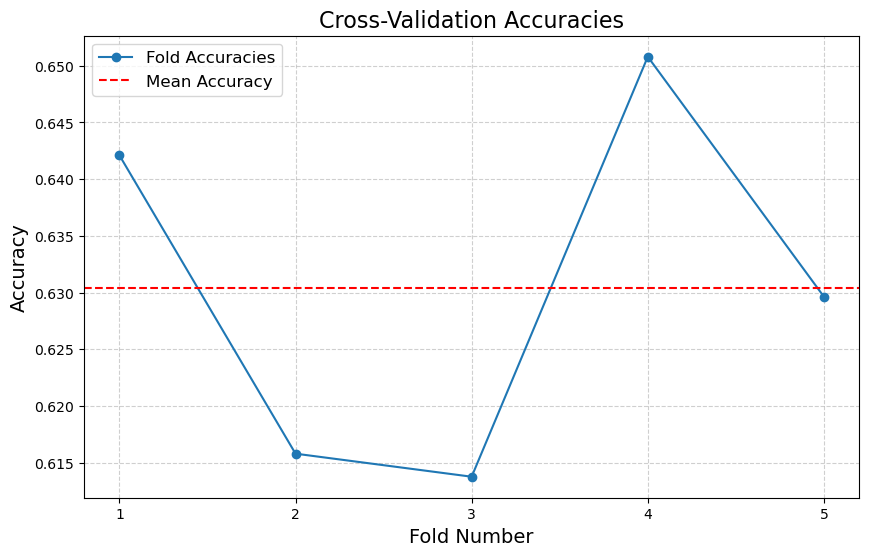

In [12]:
import matplotlib.pyplot as plt

# Plotting cross-validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', linestyle='-', label='Fold Accuracies')
plt.axhline(y=np.mean(fold_accuracies), color='r', linestyle='--', label='Mean Accuracy')

# Adding labels and title
plt.title('Cross-Validation Accuracies', fontsize=16)
plt.xlabel('Fold Number', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, len(fold_accuracies) + 1))
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()
